In [29]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
    
from matplotlib  import cm
from keras.utils import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Input
from keras.models import Model
from keras.callbacks   import ModelCheckpoint, EarlyStopping
from sklearn.metrics   import roc_curve, auc, confusion_matrix
from sklearn.metrics   import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras  import backend as K
from matplotlib.colors import Normalize, Colormap
from sklearn.model_selection  import train_test_split
from keras.preprocessing.text import Tokenizer

## Input tokenized and padded

In [2]:
# Load your data
# sData = pd.read_csv('/content/drive/MyDrive/clean_data.csv')
df = pd.read_csv('clean_data.csv')

sentences = df['headline'].tolist()
labels = df['is_sarcastic'].tolist()

# Split the data into training and test sets
sentences_train, sentences_test, labels_train, labels_test = train_test_split(sentences, 
                                                                              labels, 
                                                                              test_size=0.2, 
                                                                              random_state=2456)

# Tokenization and padding
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(sentences_train)
word_index = tokenizer.word_index
# print(word_index)

# Define a fixed sequence length
max_sequence_length_train = 30

# Pad sequences for both training and test sets
seq_train = tokenizer.texts_to_sequences(sentences_train)
seq_test  = tokenizer.texts_to_sequences(sentences_test)
# print(seq_test)
# print("---")

padded_seq_train = pad_sequences(seq_train, padding="post",
                                 maxlen=max_sequence_length_train)
padded_seq_test  = pad_sequences(seq_test, padding="post",
                                 maxlen=max_sequence_length_train)
# print(padded_seq_test)
# print("---")

# Convert labels to numpy arrays for both training and test sets
labels_train = np.array(labels_train)
labels_test  = np.array(labels_test)

# print(labels_test)

## Baseline: Logistic Regression

**something something better with epoch**

In [3]:
history_1 = lg_model.fit(padded_seq_train, labels_train,
                         epochs = 5,
                         validation_data = (padded_seq_test, labels_test))

NameError: name 'lg_model' is not defined

## Model: LSTM + Attention

In [4]:
class AttentionLayers(tf.keras.layers.Layer):
    def __init__(self, return_attention=False, **kwargs):
        super(AttentionLayers, self).__init__(**kwargs)
        self.return_attention = return_attention

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="normal")
        super(AttentionLayers, self).build(input_shape)

    def call(self, x):
        et = tf.keras.backend.squeeze(tf.keras.backend.dot(x, self.W), axis=-1)
        at = tf.keras.backend.exp(et)
        at_sum = tf.keras.backend.sum(at, axis=1, keepdims=True)
        at = at / at_sum
        at = tf.keras.backend.expand_dims(at, axis=-1)
        output = x * at
        if self.return_attention:
            return [tf.keras.backend.sum(output, axis=1), at]
        else:
            return tf.keras.backend.sum(output, axis=1)


# Define the model with attention mechanism
input_layer = Input(shape=(max_sequence_length_train,))
embedding_layer = Embedding(input_dim=len(word_index) + 1, output_dim=64,
                            input_length=max_sequence_length_train)(input_layer)
lstm_layer = LSTM(64, return_sequences=True)(embedding_layer)
attention_output, attention_weights = AttentionLayers(return_attention=True)(lstm_layer)
output_layer = Dense(1, activation='sigmoid')(attention_output)
attention_model = Model(inputs=input_layer, outputs=[output_layer, attention_weights])

# Compile and train the model with attention mechanism
attention_model.compile(loss='binary_crossentropy', optimizer='adam',
                        metrics=['accuracy'])
attention_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30)]              0         
                                                                 
 embedding (Embedding)       (None, 30, 64)            1454784   
                                                                 
 lstm (LSTM)                 (None, 30, 64)            33024     
                                                                 
 attention_layers (Attentio  [(None, 64),              64        
 nLayers)                     (None, 30, 1)]                     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 1487937 (5.68 MB)
Trainable params: 1487937 (5.68 MB)
Non-trainable params: 0 (0.00 Byte)
_______________________

In [5]:
history_2 = attention_model.fit(padded_seq_train, labels_train,
                                epochs = 5,
                                validation_data = (padded_seq_test, labels_test))

Epoch 1/5
611/611 [==============================] - 17s 24ms/step - loss: 2.0609 - dense_loss: 0.4135 - attention_layers_loss: 1.6475 - dense_accuracy: 0.8082 - attention_layers_accuracy: 0.5208 - val_loss: 1.9761 - val_dense_loss: 0.3395 - val_attention_layers_loss: 1.6366 - val_dense_accuracy: 0.8517 - val_attention_layers_accuracy: 0.5241
Epoch 2/5
611/611 [==============================] - 14s 23ms/step - loss: 1.8465 - dense_loss: 0.1990 - attention_layers_loss: 1.6475 - dense_accuracy: 0.9237 - attention_layers_accuracy: 0.5208 - val_loss: 1.9982 - val_dense_loss: 0.3616 - val_attention_layers_loss: 1.6366 - val_dense_accuracy: 0.8466 - val_attention_layers_accuracy: 0.5241
Epoch 3/5
611/611 [==============================] - 14s 23ms/step - loss: 1.7598 - dense_loss: 0.1123 - attention_layers_loss: 1.6475 - dense_accuracy: 0.9607 - attention_layers_accuracy: 0.5208 - val_loss: 2.0945 - val_dense_loss: 0.4579 - val_attention_layers_loss: 1.6366 - val_dense_accuracy: 0.8351 - val

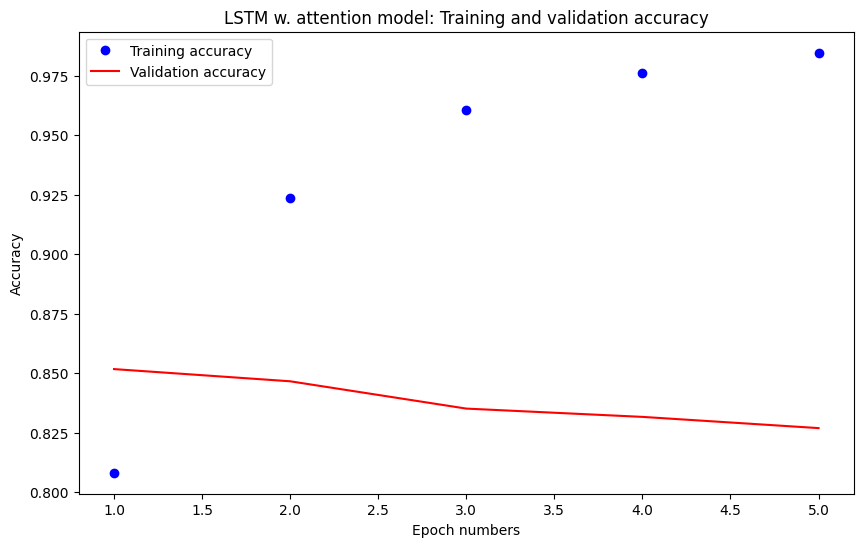

In [6]:
plt.figure(figsize=(10, 6), dpi=100)
acc = history_2.history['dense_accuracy']
val_acc = history_2.history['val_dense_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.legend()
plt.xlabel("Epoch numbers")
plt.ylabel("Accuracy")
plt.title('LSTM w. attention model: Training and validation accuracy')
plt.savefig('LSTM_ATT_acc_plot.png')
plt.show()

153/153 [==============================] - 1s 7ms/step


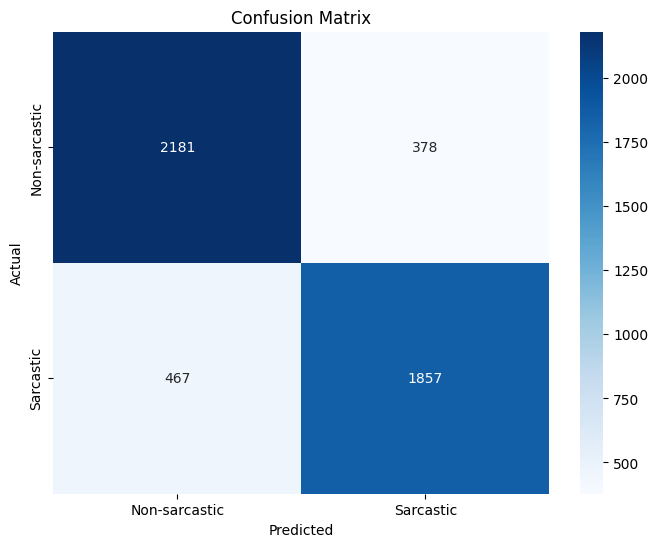

In [7]:
prob   = attention_model.predict(padded_seq_test)[0]
y_pred = (prob > 0.5).astype("int32")

cm = confusion_matrix(labels_test, y_pred)

# Plotting
plt.figure(figsize=(8, 6), dpi=100)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-sarcastic', 'Sarcastic'],
            yticklabels=['Non-sarcastic', 'Sarcastic'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

1/1 [==============================] - 0s 24ms/step
[[0.97714484]]


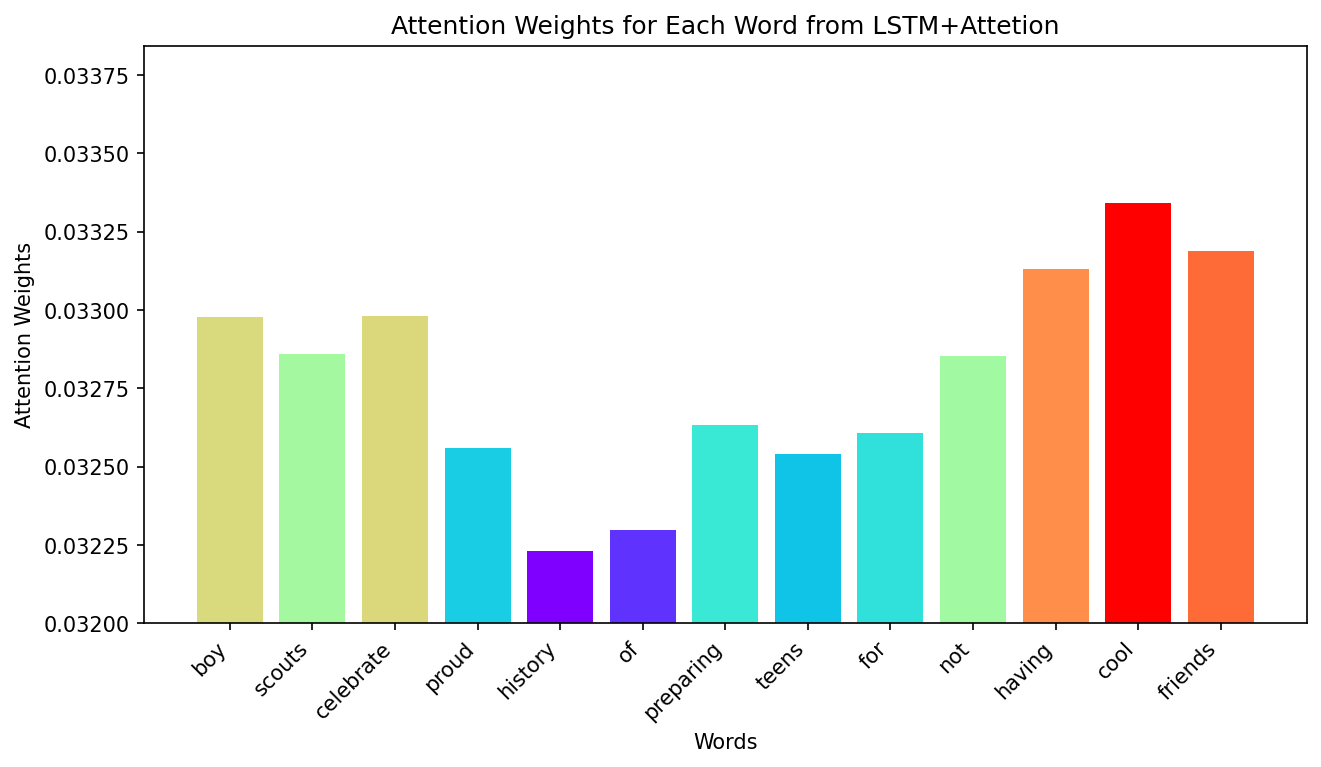

In [41]:
def visualize_attention_weights(sentence, model, tokenizer):
    sequence = tokenizer.texts_to_sequences([sentence])
    padded_sequence = pad_sequences(sequence, padding="post",
                                    maxlen=max_sequence_length_train)

    # get the attention weights
    prediction, attention_weights = model.predict(padded_sequence)
    print(prediction)
    
    # handle the example
    words = sentence.split()
    num_words = len(words)

    # trim the length
    attention_weights = attention_weights[0, :num_words].reshape(-1)
    
    # normalize the attention weights to range [0, 1] for color mapping
    attention_weights_log = np.log(attention_weights + 1e-5)  
    normalized_weights_log = (attention_weights_log - np.min(attention_weights_log)) / (np.max(attention_weights_log) - np.min(attention_weights_log))
    cols = cm.rainbow(normalized_weights_log)

    # plot
    plt.figure(figsize=(10, 5),dpi=150)
    plt.bar(np.arange(num_words), attention_weights, color=cols)
    plt.xticks(np.arange(num_words), words, rotation=45, ha='right')
    plt.xlabel('Words')
    plt.ylabel('Attention Weights')
    plt.ylim(0.032, max(attention_weights) + 0.0005)
    plt.title('Attention Weights for Each Word from LSTM+Attetion')
    plt.show()

example_1 = "boy scouts celebrate proud history of preparing teens for not having cool friends"
visualize_attention_weights(example_1, attention_model, tokenizer)

1/1 [==============================] - 0s 23ms/step
[[0.04070602]]


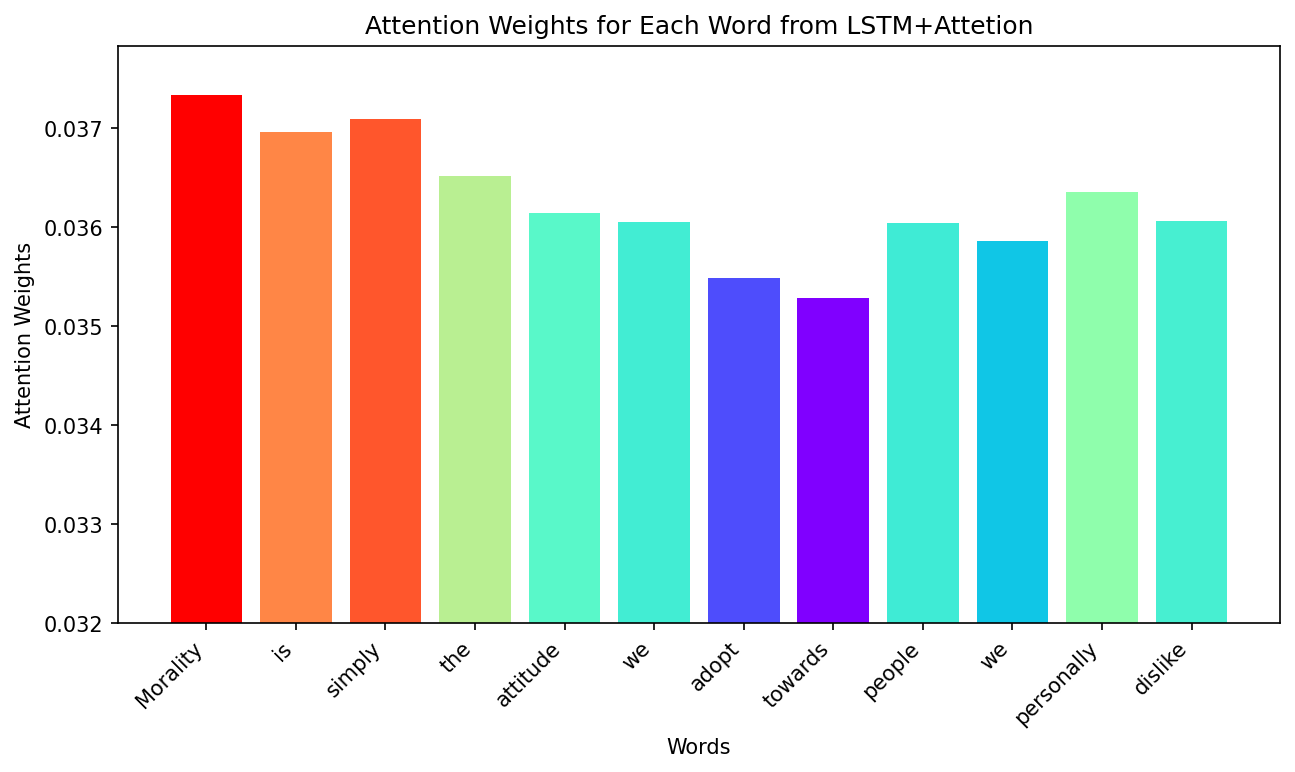

In [20]:
example_2 = "Morality is simply the attitude we adopt towards people we personally dislike"
visualize_attention_weights(example_2, attention_model, tokenizer)

1/1 [==============================] - 0s 24ms/step
[[0.003729]]


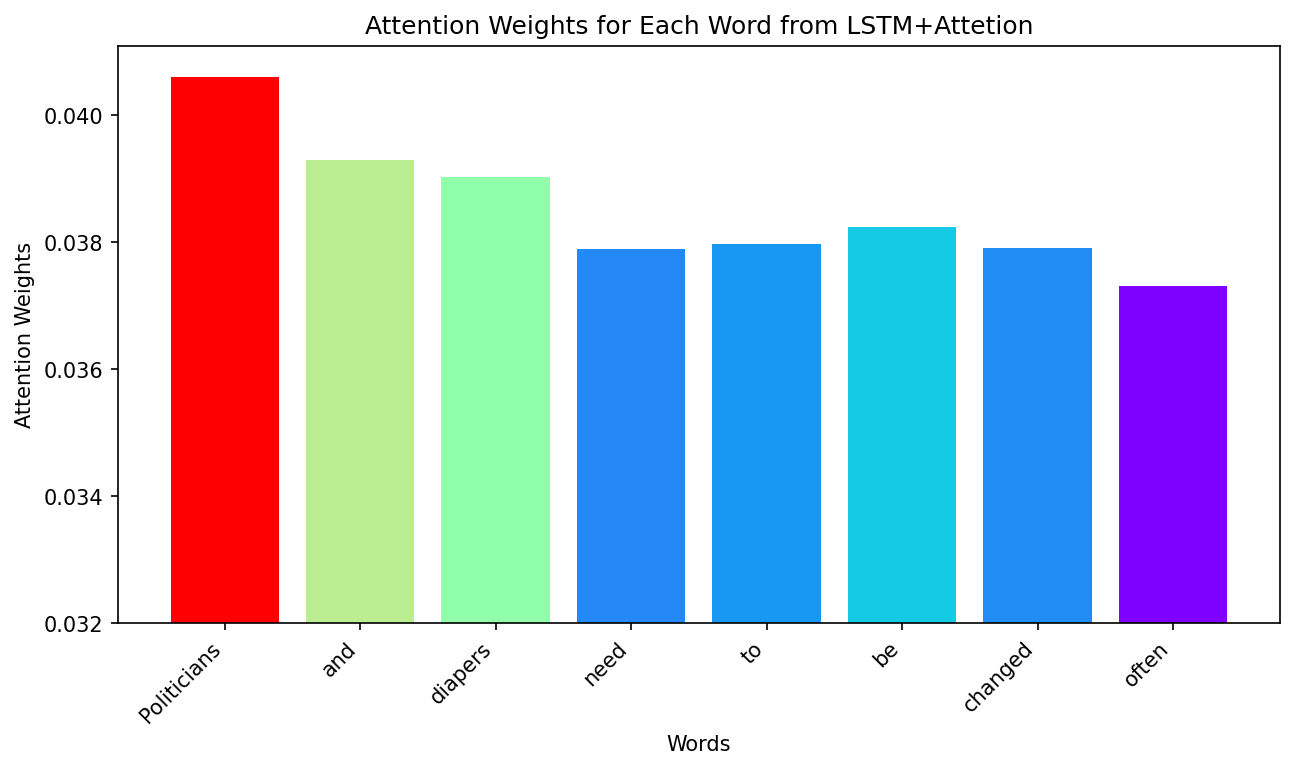

In [42]:
example_3 = "Politicians and diapers need to be changed often"
visualize_attention_weights(example_3, attention_model, tokenizer)

## Model: CNN+Bi-LSTM+Attention

In [21]:
class AttentionLayer_2(tf.keras.layers.Layer):
    """
    Keras layer to compute an attention score for each input sequence.
    """
    def __init__(self, return_attention=False, **kwargs):
        super(AttentionLayer_2, self).__init__(**kwargs)
        self.return_attention = return_attention

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight',
                                 shape=(input_shape[-1], 1),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(name='attention_bias',
                                 shape=(1, 1),
                                 initializer='zeros',
                                 trainable=True)
        super(AttentionLayer_2, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a
        if self.return_attention:
            return [K.sum(output, axis=1), a]
        return K.sum(output, axis=1)


class ConvNet(tf.keras.layers.Layer):
    def __init__(self, filter_h, out_channels):
        super(ConvNet, self).__init__()
        self.conv1d = tf.keras.layers.Conv1D(out_channels, kernel_size=filter_h,
                                             activation='relu', padding='same')

    def call(self, x):
        x = self.conv1d(x)
        return x
    
input_layer = Input(shape=(max_sequence_length_train,))
embedding_layer = Embedding(input_dim=len(word_index) + 1, output_dim=100,
                            input_length=max_sequence_length_train)(input_layer)
cnn_layer = ConvNet(5, 64)(embedding_layer)
bilstm_layer = tf.keras.layers.Bidirectional(LSTM(64, return_sequences=True))(cnn_layer)
attention_output = AttentionLayer_2(return_attention=False)(bilstm_layer)
output_layer = Dense(1, activation='sigmoid')(attention_output)

hybrid_model = Model(inputs=input_layer, outputs=output_layer)    
hybrid_model.compile(loss='binary_crossentropy', optimizer='adam',
                     metrics=['accuracy'])
hybrid_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 30)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 30, 100)           2273100   
                                                                 
 conv_net (ConvNet)          (None, 30, 64)            32064     
                                                                 
 bidirectional (Bidirection  (None, 30, 128)           66048     
 al)                                                             
                                                                 
 attention_layer_2 (Attenti  (None, 128)               129       
 onLayer_2)                                                      
                                                                 
 dense_1 (Dense)             (None, 1)                 129 

In [22]:
history_3 = hybrid_model.fit(padded_seq_train, labels_train,
                             epochs = 5,
                             validation_data = (padded_seq_test, labels_test))

Epoch 1/5


611/611 [==============================] - 23s 30ms/step - loss: 0.4144 - accuracy: 0.8002 - val_loss: 0.3275 - val_accuracy: 0.8636
Epoch 2/5
611/611 [==============================] - 18s 29ms/step - loss: 0.1620 - accuracy: 0.9391 - val_loss: 0.3675 - val_accuracy: 0.8538
Epoch 3/5
611/611 [==============================] - 18s 29ms/step - loss: 0.0525 - accuracy: 0.9830 - val_loss: 0.5276 - val_accuracy: 0.8476
Epoch 4/5
611/611 [==============================] - 18s 29ms/step - loss: 0.0184 - accuracy: 0.9946 - val_loss: 0.5611 - val_accuracy: 0.8442
Epoch 5/5
611/611 [==============================] - 18s 29ms/step - loss: 0.0076 - accuracy: 0.9978 - val_loss: 0.8458 - val_accuracy: 0.8386


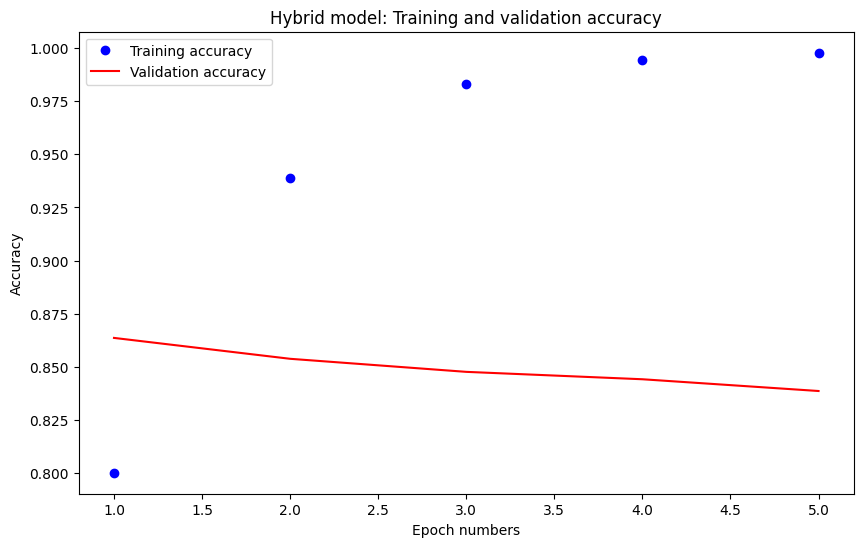

In [23]:
plt.figure(figsize=(10, 6), dpi=100)
acc = history_3.history['accuracy']
val_acc = history_3.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.legend()
plt.xlabel("Epoch numbers")
plt.ylabel("Accuracy")
plt.title('Hybrid model: Training and validation accuracy')
plt.savefig('Hybrid_acc_plot.png')
plt.show()

153/153 [==============================] - 2s 9ms/step


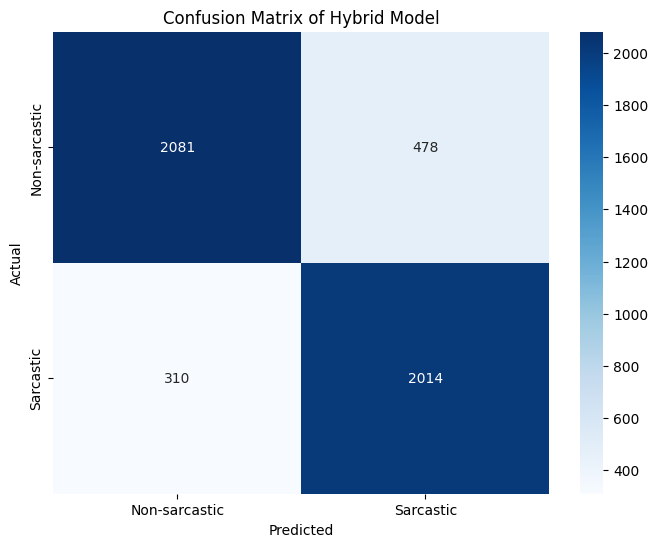

In [24]:
prob   = hybrid_model.predict(padded_seq_test)
y_pred = (prob > 0.5).astype("int32")
cm = confusion_matrix(labels_test, y_pred)

# Plotting
plt.figure(figsize=(8, 6), dpi=100)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-sarcastic', 'Sarcastic'],
            yticklabels=['Non-sarcastic', 'Sarcastic'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix of Hybrid Model')
plt.show()

1/1 [==============================] - 1s 651ms/step
[[0.99994326]]


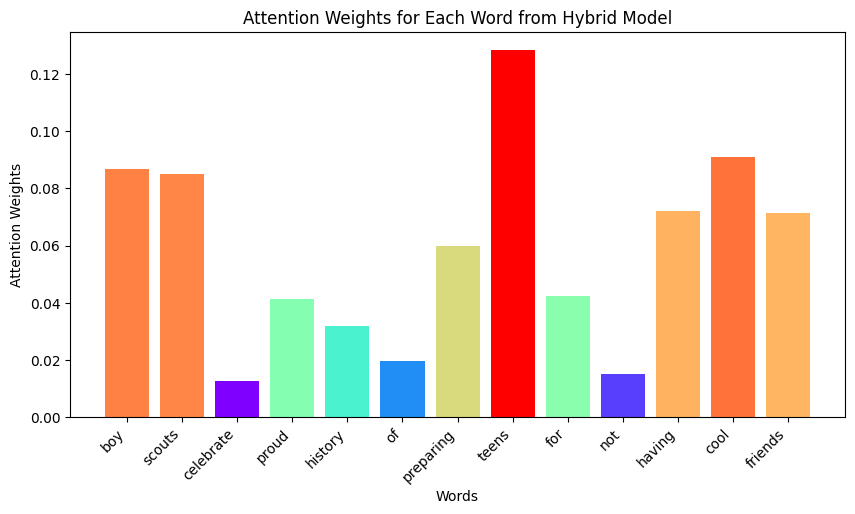

In [43]:
def visualize_attention_weights(sentence, model, tokenizer):
    # Tokenize and pad the input sentence
    sequence = tokenizer.texts_to_sequences([sentence])
    padded_sequence = pad_sequences(sequence, padding="post", maxlen=max_sequence_length_train)
    
    # Define a submodel to extract the output of the attention layer along with the attention weights
    # Replace with the correct name from the summary, if u've run it many times
    attention_layer = model.get_layer('attention_layer_2')  
    submodel = Model(inputs=model.input, outputs=[model.output, attention_layer.output])
    
    # Get the prediction and attention weights
    prediction, attention_weights = submodel.predict(padded_sequence)
    print(prediction)
    
    # The attention_weights might have an extra dimension because of the batch size
    # even if it's just one sentence
    attention_weights = np.squeeze(attention_weights)
    
    # trim the weight array
    actual_length = len(sequence[0])
    trimmed_attention_weights = attention_weights[:actual_length]
    
    # Extract the words corresponding to the tokens for visualization
    words = [tokenizer.index_word.get(token) for token in sequence[0]]
    
    # Normalize the attention weights to range [0, 1] for color mapping
    trimmed_attention_weights = np.abs(trimmed_attention_weights)
    attention_weights_log  = np.log(trimmed_attention_weights + 1e-5)  
    normalized_weights_log = (attention_weights_log - np.min(attention_weights_log)) / (np.max(attention_weights_log) - np.min(attention_weights_log))
    cols = cm.rainbow(normalized_weights_log)
    
    # Plot the attention weights
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(words)), trimmed_attention_weights, color=cols)
    plt.xticks(range(len(words)), words, rotation=45, ha='right')
    plt.xlabel('Words')
    plt.ylabel('Attention Weights')
    plt.title('Attention Weights for Each Word from Hybrid Model')
    plt.show()

# Example usage
visualize_attention_weights(example_1, hybrid_model, tokenizer)


1/1 [==============================] - 1s 661ms/step
[[0.00029238]]


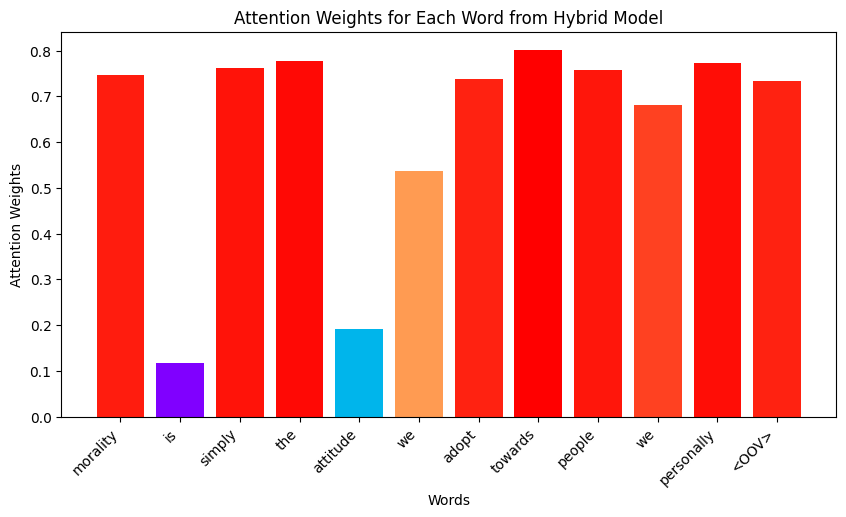

In [44]:
visualize_attention_weights(example_2, hybrid_model, tokenizer)

1/1 [==============================] - 1s 1s/step
[[0.000324]]


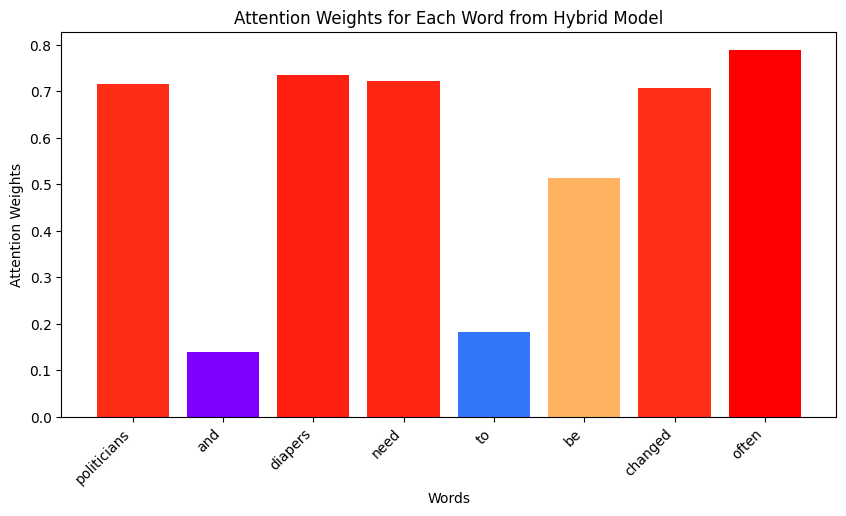

In [45]:
visualize_attention_weights(example_3, hybrid_model, tokenizer)

## Model: Transformer

## Plotting all 4 performance together 
**with epoch would be ideal**